# Importing dependencies

In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from arch import arch_model
from arch.__future__ import reindexing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

# Acquiring TSLA stock data

In [5]:
data = pd.read_csv("TSLA_2022.csv")

In [6]:
data.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
240,2023-02-10,202.229996,206.199997,192.889999,196.889999,196.889999,204193800
241,2023-02-13,194.419998,196.300003,187.610001,194.639999,194.639999,172475500
242,2023-02-14,191.940002,209.820007,189.440002,209.250000,209.250000,216455700
243,2023-02-15,211.759995,214.660004,206.110001,214.240005,214.240005,182108600
244,2023-02-16,210.779999,217.649994,201.839996,202.039993,202.039993,229586500
245,2023-02-17,199.990005,208.440002,197.500000,208.309998,208.309998,213080200
246,2023-02-21,204.990005,209.710007,197.220001,197.369995,197.369995,180018600
247,2023-02-22,197.929993,201.990005,191.779999,200.860001,200.860001,191828500
248,2023-02-23,203.910004,205.139999,196.330002,202.070007,202.070007,146360000
249,2023-02-24,196.330002,197.669998,192.800003,196.880005,196.880005,141965900


# Calculating and plotting the daily returns

In [7]:
data['Return'] = 100 * (data['Adj Close'].pct_change())

Text(0.5, 1.0, 'Daily Returns Over Time')

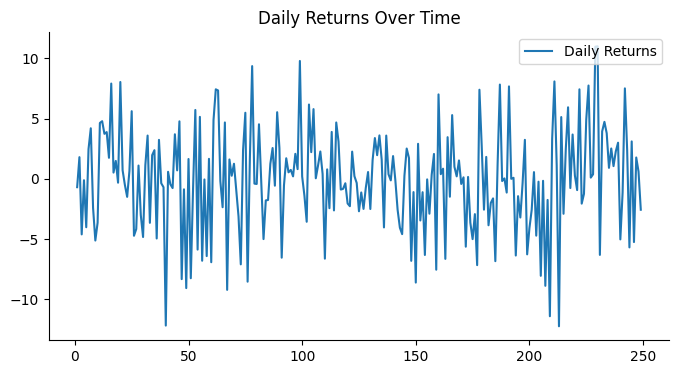

In [8]:
data.dropna(inplace=True)

fig,ax = plt.subplots(figsize=(8,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(data['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')

# Calculating daily, monthly and annual volatility

In [9]:

daily_volatility = data['Return'].std()

monthly_volatility = math.sqrt(21) * daily_volatility

annual_volatility = math.sqrt(252) * daily_volatility

print(tabulate([['Tesla',daily_volatility,monthly_volatility,annual_volatility]],headers = ['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Tesla │         4.24         │         19.42          │         67.26         │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛


# ACF & PACF 

C:\Users\maart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


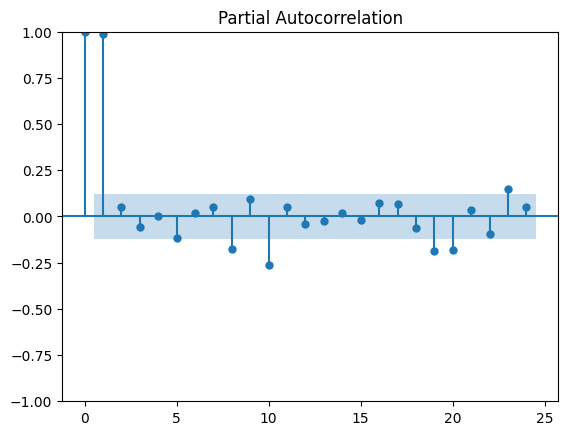

In [11]:
plot_pacf(data['Adj Close']**2)
plt.show()

# Buliding a GARCH(1,1) model

In [12]:
garch_model = arch_model(data['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 1) # Q:What does horizon mean here? 
print(gm_forecast.variance[-1:])              # A:The nr of steps ahead FC

mu         -0.082377
omega       0.723422
alpha[1]    0.040827
beta[1]     0.920292
Name: params, dtype: float64


           h.1
249  18.727395


In [13]:
gm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -710.119
Distribution:                  Normal   AIC:                           1428.24
Method:            Maximum Likelihood   BIC:                           1442.31
                                        No. Observations:                  249
Date:                Wed, Mar 08 2023   Df Residuals:                      248
Time:                        15:40:02   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0824      0.255     -0.323      0.747 [ -0.583,  0.418]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.7234      0.461      1.570      0.117      [ -0.180,  1.627]
alpha[1]       0.0408  2.563e-02      1.593      0.111 [-9.413e-03,9.107e-02]
beta[1]        0.9203  2.583e-02     35.634 4.217e-278      [  0.870,  0.971]
=============================================================================

Covariance estimator: robust
"""

# Building an E-GARCH(1,1) model

In [22]:
egarch_model = arch_model(data['Return'], p=1, o=1, q=1,
                          mean='constant', vol='EGARCH', dist='normal')

egm_result = egarch_model.fit(disp='off')
print(egm_result.params)

print('\n')

egm_forecast = egm_result.forecast(horizon=1)
print(egm_forecast.variance[-1:])
print(egm_result.summary())



mu         -0.063749
omega       0.077275
alpha[1]   -0.447838
alpha[2]    0.273067
gamma[1]    0.158630
gamma[2]   -0.273826
beta[1]     0.415707
beta[2]     0.557781
Name: params, dtype: float64


          h.1
249  6.238081
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -692.048
Distribution:                  Normal   AIC:                           1400.10
Method:            Maximum Likelihood   BIC:                           1428.24
                                        No. Observations:                  249
Date:                Wed, Mar 08 2023   Df Residuals:                      248
Time:                        15:54:17   Df Model:                            1
                                  Mean Model                  

# EGARCH MODEL V2

In [24]:
#https://www.oreilly.com/library/view/machine-learning-for/9781492085249/ch04.html#egarch_vol
# Define model
egarch_sentiment = arch.arch_model(df['log_returns'],mean='constant', vol='EGARCH', p=1, o=1, q=1)

NameError: name 'arch' is not defined

In [ ]:
n = 252
split_date = df['log_returns'].iloc[-n:].index 

In [ ]:
#
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch.arch_model(df['log_returns'], mean='constant', vol='EGARCH', p=p, q=q)\
                .fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch.arch_model(df['log_returns'], x=df['reg_output'], mean='constant', vol='EGARCH',
                    p=best_param[0], q=best_param[1])\
        .fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

In [ ]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                                  np.sqrt(forecast_garch\
                                  .variance.iloc[-len(split_date):]
                                  / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))
The RMSE value of GARCH model is 0.0878

In [23]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100,
label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

NameError: name 'realized_vol' is not defined

<Figure size 1000x600 with 0 Axes>

# [NOT USED] Rolling Predictions


In [15]:
# training data size = 200 (80%)
# test data size = 50 (20%)

Text(0.5, 1.0, 'Rolling Prediction')

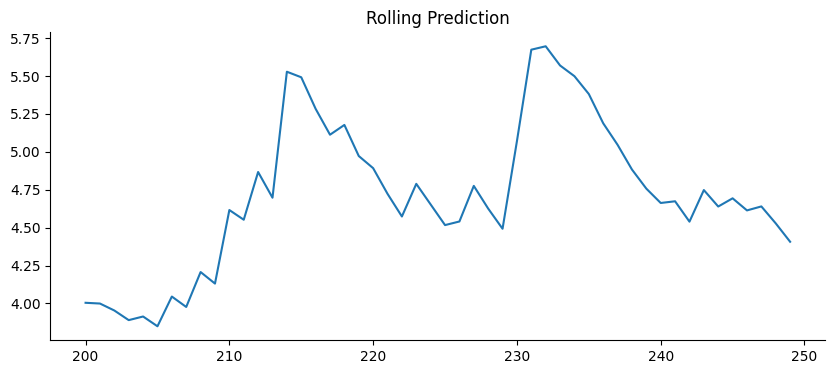

In [16]:
rolling_predictions = []
test_size = 50

for i in range(test_size):
    train = data['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1) #could the horizen be the number of periods we want to FC
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=data['Return'].index[-50:])

fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')

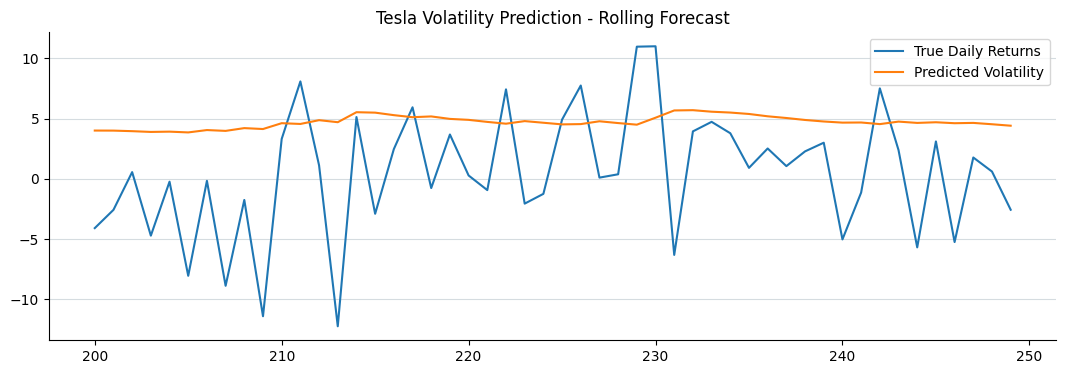

In [17]:
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(data['Return'][-50:])
plt.plot(rolling_predictions)
plt.title('Tesla Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])

# [NOT USED] Fitting the rolling prediction model and relevant statistics

In [18]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -707.559
Distribution:                  Normal   AIC:                           1423.12
Method:            Maximum Likelihood   BIC:                           1437.17
                                        No. Observations:                  248
Date:                Wed, Mar 08 2023   Df Residuals:                      247
Time:                        15:40:04   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0747      0.256     -0.292      0.770 [ -0.576,  0.427]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.7029      0.451      1.558      0.119      [ -0.181,  1.587]
alpha[1]       0.0407  2.538e-02      1.605      0.108 [-9.005e-03,9.050e-02]
beta[1]        0.9218  2.507e-02     36.761 7.786e-296      [  0.873,  0.971]
=============================================================================

Covariance estimator: robust
"""